### Import Dependencies

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
from tqdm import tnrange
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import math

### Make sure computation is running on GPU

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('This Computation is running on {}'.format(device))

This Computation is running on cpu


### For any arbitraty number, get the closest values where the root squre is integer valued
(Just to make sure that the plot of Encoding later stays squared)

In [3]:
def closest_isqrt(n):
    def _is_isqrt(x):
        if math.sqrt(x).is_integer():
            return True
        return False

    for i in range(1000):
        if _is_isqrt(n-i):
            return n-i
        if _is_isqrt(n+i):
            return n+i

### Load Data and set meta info

In [4]:
train_batch_size = 64
val_batch_size = 512
channels = 1
image_size = 28
input_dim = channels*image_size*image_size

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
valset = datasets.MNIST('./data', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=val_batch_size, shuffle=True)

### Set Autoencoder Encoding Parameter

In [5]:
encoder_layers = 5
scaling = 0.4
size = [closest_isqrt(int(input_dim*scaling**i)) for i in range(encoder_layers)] #make sure each dimreduction step may still returns a rectangular image

print(size)
print('Model will have {} Layers, with {} Neurons in the smallest Layer ({}% of Orginial Object Size)'.format(encoder_layers*2,size[-1],round((size[-1]/input_dim)*100,1)))

[784, 324, 121, 49, 16]
Model will have 10 Layers, with 16 Neurons in the smallest Layer (2.0% of Orginial Object Size)


In [6]:
def flat(x):
    return x.view(-1,channels*image_size*image_size)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder_layers = nn.ModuleList([nn.Linear(size[i], size[i+1]) for i in range(encoder_layers-1)])
        self.decoder_layers = nn.ModuleList([nn.Linear(size[i+1], size[i]) for i in reversed(range(encoder_layers-1))])

    def encoder(self,x):
        x = x.view(-1, input_dim)

        for i, layer in enumerate(self.encoder_layers):
            x = F.relu(layer(x))
        return x

    def decoder(self,x):
        for i, layer in enumerate(self.decoder_layers):
            x = F.relu(layer(x))
        return x

    def forward(self, x):
        if torch.cuda.is_available():
            x = x.to(device)

        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [7]:
if torch.cuda.is_available():
    model = Autoencoder().cuda()
else:
    model = Autoencoder().cpu()

distance = nn.MSELoss()
optimizer = optim.SGD(model.parameters(),lr=0.1,momentum=0.9)
epoch_train_loss = []
epoch_val_loss = []

In [8]:
epochs = 100
for epoch in tnrange(epochs, desc='Epochs',unit='Epoch'):
    train_batch_loss = []
    for img, _ in trainloader:

        optimizer.zero_grad()

        if torch.cuda.is_available():
            img = img.to(device)

        output = model(img)

        loss = distance(output, img.view(-1,input_dim))


        loss.backward(retain_graph=True)
        optimizer.step()

        train_batch_loss.append(loss.item())

    print('Loss in Epoch: {}'.format(np.mean(train_batch_loss)))
    epoch_train_loss.append(np.mean(train_batch_loss))

/var/folders/6z/jr7vc1n52qlbyvvf98jx_y580000gn/T/ipykernel_51137/4062615545.py:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for epoch in tnrange(epochs, desc='Epochs',unit='Epoch'):


Epochs:   0%|          | 0/100 [00:00<?, ?Epoch/s]

Loss in Epoch: 0.9256411244365961
Loss in Epoch: 0.9253143293898243
Loss in Epoch: 0.9251577521819295
Loss in Epoch: 0.9239191346204103
Loss in Epoch: 0.9226420348895384
Loss in Epoch: 0.9222066665509108
Loss in Epoch: 0.9215608070781236
Loss in Epoch: 0.9183003688926128
Loss in Epoch: 0.9143319785086585
Loss in Epoch: 0.9117962939144452
Loss in Epoch: 0.9089960626193455
Loss in Epoch: 0.9063924756258536
Loss in Epoch: 0.903801801934171
Loss in Epoch: 0.9010992528024767
Loss in Epoch: 0.8985162521603265
Loss in Epoch: 0.8964941241085402
Loss in Epoch: 0.8947901747374138
Loss in Epoch: 0.8934531422184983
Loss in Epoch: 0.8916597210649234
Loss in Epoch: 0.8900177464175072
Loss in Epoch: 0.8887167239367072
Loss in Epoch: 0.887170792324965
Loss in Epoch: 0.8856715590460722
Loss in Epoch: 0.8842709943938103
Loss in Epoch: 0.8827484235453453
Loss in Epoch: 0.8814662755933652
Loss in Epoch: 0.8803395073551105
Loss in Epoch: 0.8795465256359531
Loss in Epoch: 0.8788497307534411
Loss in Epoch: 0

### See how MSE Loss developed of Epochs in Train Dataset

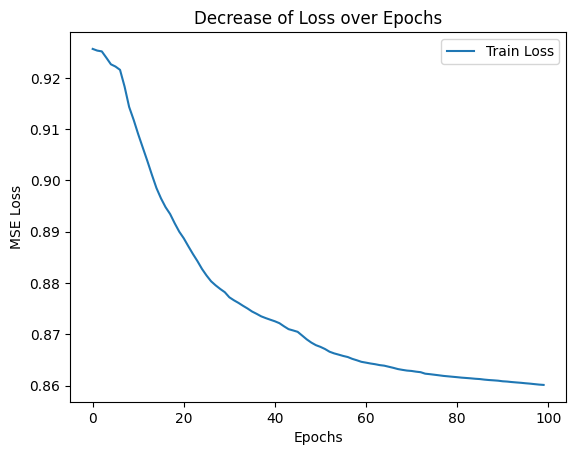

In [9]:
plt.plot(epoch_train_loss,label='Train Loss')
plt.title('Decrease of Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Compare Original Image with Encoding and Reconstruction from Autoencoder

In [10]:
def show_images(img_list,columns=3):
    columns = min(columns,len(img_list))
    rows = math.ceil(len(img_list)/columns)
    f, axes = plt.subplots(rows, columns,figsize=(10, 6*rows))
    for i, obj in enumerate(img_list):
        obj['image'] = obj['image'] / 2 + 0.5     # unnormalize
        obj['image'] = obj['image'].numpy()
        axes[i].imshow(obj['image'])
        axes[i].title.set_text(obj['title'])
        if obj['ticks'] == False:
            plt.setp(axes[i].get_xticklabels(), visible=False)
            plt.setp(axes[i].get_yticklabels(), visible=False)
            axes[i].tick_params(axis='both', which='both', length=0)

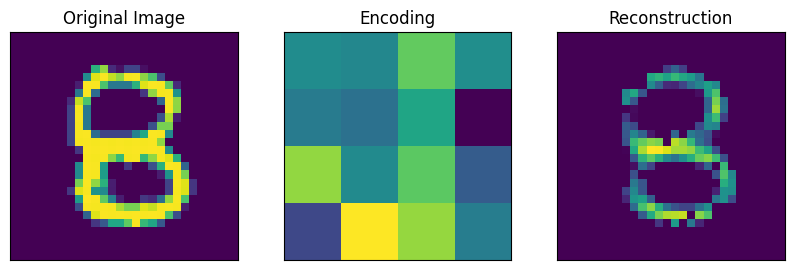

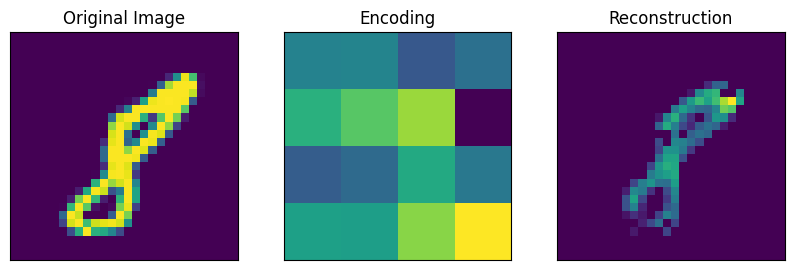

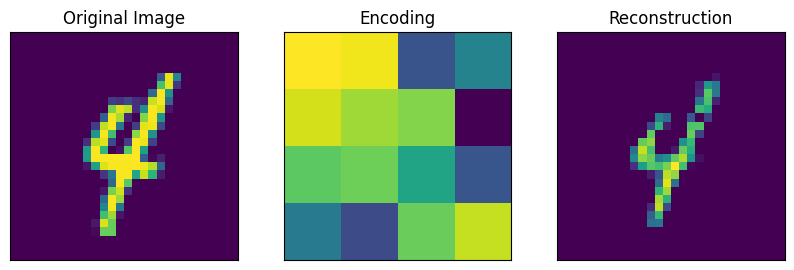

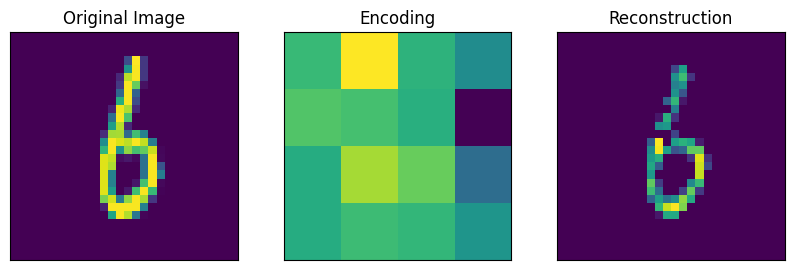

In [11]:
if not math.sqrt(size[-1]).is_integer():
    print("Encoding is not Squared")
else:
    for i, data in enumerate(trainloader):
        inputs, _ = data

        encoding = model.encoder(inputs.to(device)).detach().cpu()
        encoding = encoding[0].view(1,channels,int(math.sqrt(size[-1])),int(math.sqrt(size[-1])))

        reconstruction = model(inputs.to(device)).detach().cpu()
        reconstruction = reconstruction.view(train_batch_size,channels,image_size,image_size)


        show_images([{'image':inputs[0].squeeze(),'title':'Original Image','ticks':False},
                  {'image':encoding[0].squeeze(),'title':'Encoding','ticks':False},
                  {'image':reconstruction[0].squeeze(),'title':'Reconstruction','ticks':False}])

        if i == 3:
            break